# Building a Neural Network for Klickwell Database

Loading the data and doing applying feature engineering for some features

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

horse_data = pd.read_csv("datacarreras.csv")

# Wins/Starts
horse_data['effect_jinete'] = round(horse_data["jinete_gana"] / horse_data["jinete_act"] * 100, 2)
horse_data['effect_trainer'] = round(horse_data["trainer_gana"] / horse_data["trainer_act"] * 100, 2)

# Filtering and replacing values

horse_data = horse_data.replace(np.inf, 30)
horse_data = horse_data[(horse_data.resultado != 0)]
horse_data["jinete_rep_mon"].replace(1, 0)
horse_data["jinete_rep_mon"].replace(3, 1)

# Amelioration of dividends with regards to last race
horse_data["mej_div"] = horse_data["penult_div"] - horse_data["ult_div"]

horse_data["distancia_pista"].value_counts()

1200    443
1300    273
1400    244
1100    203
1600     41
1500     33
1800     19
1900     12
2400     12
Name: distancia_pista, dtype: int64

In [2]:
horse_data.head()

,fecha,numero_carrera,distancia_pista,grupo,nombre_caballo,tiempo,ult_div,penult_div,posicion,cuerpos_ult,...,lote,jinete_act,jinete_gana,jinete_rep_mon,trainer_act,trainer_gana,resultado,effect_jinete,effect_trainer,mej_div
0,08-11-2020,1,1800,2,ironhide,113.0,2100,2300,2,4.25,...,2,122,16,3,49,5,6,13.11,10.20,200
1,08-11-2020,1,1800,2,el ferretero,114.2,10000,10000,7,11.25,...,3,69,1,1,50,0,3,1.45,0.00,0
2,08-11-2020,1,1800,2,matheew star,115.0,350,350,5,6.50,...,3,43,5,3,93,8,4,11.63,8.60,0
3,08-11-2020,1,1800,2,power indy,113.3,450,600,3,6.50,...,3,99,14,1,146,19,1,14.14,13.01,150
4,08-11-2020,1,1800,2,gran giacomo,115.2,540,540,1,0.00,...,1,92,23,1,31,6,8,25.00,19.35,0


In [3]:
horse_data["resultado"].value_counts()

3     123
2     121
1     121
5     118
4     118
7     115
6     111
8     106
9      99
10     84
11     64
12     53
13     36
14     11
Name: resultado, dtype: int64

Filtering out some irrelevant data and replacing zeros with the mean value of he column

In [4]:
horse_data = horse_data[['distancia_pista', 'tiempo', 'penult_div','ult_div', 'mej_div','posicion','cuerpos_ult', 'distancia_c', 'lote', 'jinete_gana', 'effect_jinete', 'jinete_rep_mon', 'trainer_gana','effect_trainer', 'resultado']]
horse_data["ult_div"].replace(0, horse_data["ult_div"].mean(axis=0), inplace=True)
horse_data["mej_div"].replace(0, horse_data["mej_div"].mean(axis=0), inplace=True)
horse_data.head()

,distancia_pista,tiempo,penult_div,ult_div,mej_div,posicion,cuerpos_ult,distancia_c,lote,jinete_gana,effect_jinete,jinete_rep_mon,trainer_gana,effect_trainer,resultado
0,1800,113.0,2300,2100.0,200.000000,2,4.25,2,2,16,13.11,3,5,10.20,6
1,1800,114.2,10000,10000.0,-212.833594,7,11.25,1,3,1,1.45,1,0,0.00,3
2,1800,115.0,350,350.0,-212.833594,5,6.50,2,3,5,11.63,3,8,8.60,4
3,1800,113.3,600,450.0,150.000000,3,6.50,3,3,14,14.14,1,19,13.01,1
4,1800,115.2,540,540.0,-212.833594,1,0.00,2,1,23,25.00,1,6,19.35,8


Any result over 6 gets put in the 6 category which could be called loosers, since there are a lot of values the neural network would just pradict as much 6s as possible so better leave this out for the momment until finding a workaround for this.

In [ ]:
#horse_data['resultado'] -= 1

#for i in horse_data['resultado']:
#    if i > 6:
#        horse_data['resultado'].replace(i, 6, inplace=True)
        
horse_data

Divide the races by distances, separating long distance races and short distance into 2 separate groups of data. Horses in Venezuela are prone to lose in long distance races if they have only ran races bellow 1200 mts. Also, the neural network will only get input for the horses that arrived in the first 5 positions, since the program Klickwell already have a good percentage of having the winning horse in its 4 picks.

And make a category for generating a stratified sampling of the data.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


<AxesSubplot:>

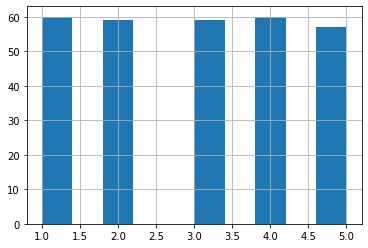

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

carreras_1200 = horse_data.loc[horse_data['distancia_pista'] <= 1200]
carreras_1200_gana = carreras_1200.loc[horse_data['resultado'] <= 5]
carreras_1300_plus = horse_data.loc[horse_data['distancia_pista'] >=1300]
carreras_1300_plus_gana = carreras_1300_plus.loc[horse_data['resultado'] <= 5]

carreras_1200_gana["resultado_cat"] = pd.cut(carreras_1200_gana["resultado"], bins=[0., 1, 2, 3, 4, 5], labels=[1, 2, 3, 4, 5])
carreras_1300_plus_gana["resultado_cat"] = pd.cut(carreras_1300_plus_gana["resultado"], bins=[0., 1, 2, 3, 4, 5], labels=[1, 2, 3, 4, 5])

carreras_1300_plus_gana["resultado_cat"].hist()

In [6]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in split.split(carreras_1200_gana, carreras_1200_gana["resultado_cat"]):
    carreras_1200_train_strat = carreras_1200_gana.iloc[train_index]
    carreras_1200_test_strat = carreras_1200_gana.iloc[test_index]
    
for train_index, test_index in split.split(carreras_1300_plus_gana, carreras_1300_plus_gana["resultado_cat"]):
    carreras_1300_train_strat = carreras_1300_plus_gana.iloc[train_index]
    carreras_1300_test_strat = carreras_1300_plus_gana.iloc[test_index]

In [7]:
carreras_1300_test_strat["resultado_cat"].value_counts() / len(carreras_1300_test_strat)

5    0.2
4    0.2
3    0.2
2    0.2
1    0.2
Name: resultado_cat, dtype: float64

In [8]:
for set_ in (carreras_1200_train_strat, carreras_1200_test_strat):
    set_.drop("resultado_cat", axis=1, inplace=True)
    
for set_ in (carreras_1300_train_strat, carreras_1300_test_strat):
    set_.drop("resultado_cat", axis=1, inplace=True)

/home/Nj1991/.local/lib/python3.7/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Looking at the correlations

In [9]:
horse_corr_matrix_1300_plus = carreras_1300_plus_gana.corr()
horse_corr_matrix_1300_plus['resultado'].sort_values(ascending=True)

jinete_gana       -0.148244
effect_jinete     -0.130815
effect_trainer    -0.116217
trainer_gana      -0.087582
distancia_c       -0.070466
lote              -0.055280
mej_div           -0.043274
distancia_pista    0.003763
jinete_rep_mon     0.016622
tiempo             0.029818
penult_div         0.170154
ult_div            0.209363
cuerpos_ult        0.212176
posicion           0.234942
resultado          1.000000
Name: resultado, dtype: float64

In [10]:
horse_corr_matrix_1200 = carreras_1200_gana.corr()
horse_corr_matrix_1200['resultado'].sort_values(ascending=True)

effect_jinete     -0.150652
distancia_c       -0.139777
mej_div           -0.091707
jinete_rep_mon    -0.077193
trainer_gana      -0.064482
effect_trainer    -0.035140
jinete_gana       -0.033050
distancia_pista   -0.031332
lote              -0.000439
tiempo             0.037428
penult_div         0.140726
ult_div            0.211907
cuerpos_ult        0.233131
posicion           0.245899
resultado          1.000000
Name: resultado, dtype: float64

Seems like position, bodies, dividends and effectiveness of the jokey and trainer have some correlation in both datasets, although not high enough. Next, in the results column, substract one, since keras to_categorical gives of an error if there is no zero value. (Keras Version 2.3.0)

In [11]:
carreras_1200_train_strat['resultado'] -= 1
carreras_1300_train_strat['resultado'] -= 1

carreras_1200_r = carreras_1200_train_strat["resultado"].copy()
carreras_1300_plus_r = carreras_1300_train_strat["resultado"].copy()

carreras_1200_train_strat.drop("resultado", axis=1)
carreras_1300_train_strat.drop("resultado", axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,distancia_pista,tiempo,penult_div,ult_div,mej_div,posicion,cuerpos_ult,distancia_c,lote,jinete_gana,effect_jinete,jinete_rep_mon,trainer_gana,effect_trainer
1088,1300,80.4,800,700.0,100.000000,3,3.50,3,3,20,13.70,3,2,16.67
530,1300,81.4,260,450.0,-190.000000,4,8.25,3,3,3,9.38,1,13,18.06
470,1300,82.1,1600,1000.0,600.000000,2,3.00,3,3,5,7.25,3,5,7.25
494,1400,87.1,1500,300.0,1200.000000,2,0.50,3,3,19,14.18,1,17,14.78
966,1300,79.2,300,300.0,-212.833594,2,0.10,3,4,18,14.40,1,18,13.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,1800,115.0,350,350.0,-212.833594,5,6.50,2,3,5,11.63,3,8,8.60
1068,1300,78.3,550,550.0,-212.833594,2,0.50,3,3,14,17.07,1,25,18.52
1112,1300,81.1,600,900.0,-300.000000,2,4.75,3,3,0,0.00,1,8,17.02
527,1300,82.4,2900,1200.0,1700.000000,10,14.00,2,3,8,12.12,3,24,13.95


Pick the values that might yield some positive results.

In [12]:
carreras_1200_prepared = carreras_1200_train_strat[['tiempo', 'ult_div', 'penult_div', 'mej_div','posicion','cuerpos_ult', 'distancia_c', 'lote', 'effect_jinete', 'jinete_rep_mon', 'effect_trainer']]
carreras_1300_prepared = carreras_1300_train_strat[['tiempo', 'ult_div', 'penult_div', 'mej_div','posicion','cuerpos_ult', 'distancia_c', 'lote', 'effect_jinete', 'jinete_rep_mon', 'effect_trainer']]

In [13]:
carreras_1300_plus_r.value_counts()

3    54
0    54
2    53
1    53
4    51
Name: resultado, dtype: int64

Use Scikit-Learn StandardScaler to scale the data since some features are in a diferent scale from others.

In [14]:
import keras as keras
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

transform_data = Pipeline([
    ("scaler", StandardScaler())
])

X_1200, X_1200_val, y_1200, y_1200_val = train_test_split(carreras_1200_prepared, carreras_1200_r, test_size=0.1, random_state=42)
X_1300, X_1300_val, y_1300, y_1300_val = train_test_split(carreras_1300_prepared, carreras_1300_plus_r, test_size=0.1, random_state=42)

y_1200 = keras.utils.to_categorical(np.array(y_1200))
y_1300 = keras.utils.to_categorical(np.array(y_1300))

y_1200_val = keras.utils.to_categorical(np.array(y_1200_val))
y_1300_val = keras.utils.to_categorical(np.array(y_1300_val))

y_test_1200 = carreras_1200_test_strat["resultado"].copy()
y_test_1300 = carreras_1300_test_strat["resultado"].copy()

X_test_1200 = carreras_1200_test_strat[['tiempo', 'ult_div', 'penult_div', 'mej_div','posicion', 'cuerpos_ult', 'distancia_c', 'lote', 'effect_jinete', 'jinete_rep_mon', 'effect_trainer']]
X_test_1300 = carreras_1300_test_strat[['tiempo', 'ult_div', 'penult_div', 'mej_div','posicion', 'cuerpos_ult', 'distancia_c', 'lote', 'effect_jinete', 'jinete_rep_mon', 'effect_trainer']]

X_1200 = transform_data.fit_transform(X_1200)
X_1300 = transform_data.fit_transform(X_1300)

X_1200_val = transform_data.fit_transform(X_1200_val)
X_1300_val = transform_data.fit_transform(X_1300_val)

X_test_1200 = transform_data.fit_transform(X_test_1200)
X_test_1300 = transform_data.fit_transform(X_test_1300)

Using Theano backend.


In [15]:
print(f"{X_1300.shape}")
print(f"{y_1300.shape}")

(238, 11)
(238, 5)


# Sequential Dense layers model

An standard model to test. Added some weight regularizers to fight overfitting, also tried Dropout layers, but with no good results.

In [20]:
model = keras.models.Sequential([
    keras.layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.1),input_shape=(11,)),
    keras.layers.BatchNormalization(),
    #keras.layers.Dropout(rate=0.3),
    #keras.layers.Dense(32, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(48, activation="relu",kernel_regularizer=keras.regularizers.l2(0.1)),
    keras.layers.BatchNormalization(),
    #keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(5, activation="softmax")
])

model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True), 
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                384       
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
dense_6 (Dense)              (None, 48)                1584      
_________________________________________________________________
batch_normalization_4 (Batch (None, 48)                192       
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 245       
Total params: 2,533
Trainable params: 2,373
Non-trainable params: 160
_________________________________________________________________


# Sequential ConvNet1D model (To Do)

Will need to reshape the data so a ConvNet1D model can read it, at the moment will stick to the standard model.

In [17]:
#X_1300 = np.expand_dims(X_1300, axis=0)

model = keras.models.Sequential([
    keras.layers.Conv1D(32, 2,input_shape=(None, X_1300.shape[-1])),
    keras.layers.MaxPool1D(2),
    keras.layers.Conv1D(32, 1, activation='relu'),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer=keras.optimizers.RMSprop(), 
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['acc'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          736       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          1056      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
Total params: 1,957
Trainable params: 1,957
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#X_1300_val = np.expand_dims(X_1300_val, axis=0)

X_1300.shape
X_1300_val.shape

In [21]:
history = model.fit(X_1300, y_1300, epochs=50, validation_data=(X_1300_val, y_1300_val))
print("Done")

Train on 238 samples, validate on 27 samples
Epoch 1/50
238/238 [==============================] - 0s 615us/step - loss: 7.5305 - accuracy: 0.2311 - val_loss: 7.0387 - val_accuracy: 0.1111
Epoch 2/50
238/238 [==============================] - 0s 507us/step - loss: 7.3719 - accuracy: 0.2059 - val_loss: 6.9023 - val_accuracy: 0.1111
Epoch 3/50
238/238 [==============================] - 0s 480us/step - loss: 7.0834 - accuracy: 0.2269 - val_loss: 6.7526 - val_accuracy: 0.1111
Epoch 4/50
238/238 [==============================] - 0s 445us/step - loss: 6.9006 - accuracy: 0.2437 - val_loss: 6.5965 - val_accuracy: 0.1111
Epoch 5/50
238/238 [==============================] - 0s 225us/step - loss: 6.6739 - accuracy: 0.2521 - val_loss: 6.4401 - val_accuracy: 0.1111
Epoch 6/50
238/238 [==============================] - 0s 421us/step - loss: 6.4269 - accuracy: 0.2941 - val_loss: 6.2858 - val_accuracy: 0.1481
Epoch 7/50
238/238 [==============================] - 0s 342us/step - loss: 6.2260 - accura

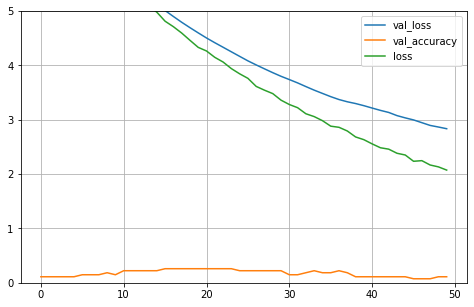

In [22]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid()
plt.legend()
plt.gca().set_ylim(0, 5)
plt.show()

In [23]:
y_test_1300 -= 1

y_test_1300 = keras.utils.to_categorical(y_test_1300)

In [24]:
model.evaluate(X_test_1300, y_test_1300)

30/30 [==============================] - 0s 40us/step


[2.71817684173584, 0.4000000059604645]

In [26]:
y_proba = model.predict(X_test_1300)

print(f"{y_proba[:6].round(2)}")
print(f"Labels: {y_test_1300[:6]}")

[[0.27 0.12 0.45 0.07 0.08]
 [0.25 0.24 0.17 0.17 0.17]
 [0.04 0.23 0.3  0.26 0.17]
 [0.19 0.12 0.2  0.27 0.22]
 [0.06 0.13 0.25 0.09 0.47]
 [0.13 0.27 0.29 0.18 0.13]]
Labels: [[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]


Although the model got poor results in the validation data, when tested on the test set it got a 40% accuracy result. The model is also overfitting, so it would be a good idea to adjust the lr value. Also, the loss for the validation data is still dropping after only 50 epochs.